In [1]:
import kornia
import torch
from torch import nn

In [2]:
def myCanny(image, stdev, tau):
    
    image = image / 255

    image_ten = torch.from_numpy(image).float()
    height, width = image_ten.shape
    image_ten = image_ten.unsqueeze(0).unsqueeze(0)
    image_ten = kornia.filters.gaussian_blur2d(image_ten,(5,5),(stdev,stdev))
    

    gradient_mag_sq = torch.zeros(height,width)
    
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            dx = image[x + 1, y] - image[x - 1, y]
            dy = image[x, y + 1] - image[x, y - 1]
            gradient_mag_sq[x, y] = dx**2 + dy**2
    
    mag = torch.norm(gradient_mag_sq,dim = 1,keepdim = True)
    unit_vector = gradient_mag_sq/mag
    for x in range(1, height - 1):
        for y in range(1, width - 1):

            p = gradient_mag_sq[x, y]
            p_plus = gradient_mag_sq[x, y] + unit_vector[x,y]
            p_minus = gradient_mag_sq[x, y] - unit_vector[x,y]

            if (p > p_plus and p >= p_minus) or (p > p_minus and p >= p_plus):
                gradient_mag_sq[x,y] = p[x,y]
            
                
    threshold_mask = gradient_mag_sq > tau
    
    
    
    return threshold_mask

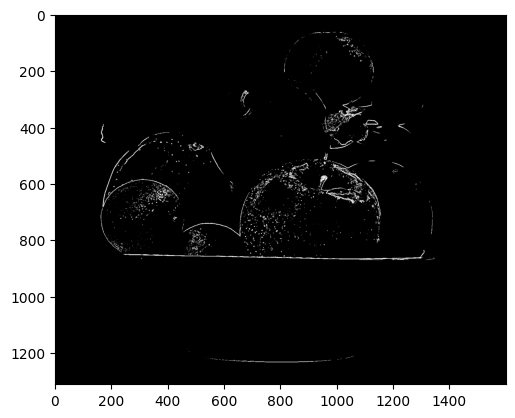

In [3]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("/cs/home/curtlac/4422 labs/bowl-of-fruit.jpg",cv2.IMREAD_GRAYSCALE)
impeaks = myCanny(image,12,0.01)
impeaks = impeaks.to(torch.float32).numpy() 
impeaks = cv2.cvtColor(impeaks,cv2.COLOR_BGR2RGB)
plt.imshow(impeaks)

In [ ]:
image = cv2.imread("/cs/home/curtlac/4422 labs/lab2im1.jpg",cv2.IMREAD_GRAYSCALE)
impeaks = myCanny(image,2,0.009)
impeaks = impeaks.to(torch.float32).numpy()
impeaks = cv2.cvtColor(impeaks,cv2.COLOR_BGR2RGB)
plt.imshow(impeaks)

In [ ]:
import queue
def myCannyFull(image,stdev,highthresh,lowthresh):
    
    image = image / 255

    image_ten = torch.from_numpy(image).float()
    height, width = image_ten.shape
    image_ten = image_ten.unsqueeze(0).unsqueeze(0)
    image_ten = kornia.filters.gaussian_blur2d(image_ten,(5,5),(stdev,stdev))
    

    gradient_mag_sq = torch.zeros(height,width)
    edges = torch.zeros(height,width)
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            dx = image[x + 1, y] - image[x - 1, y]
            dy = image[x, y + 1] - image[x, y - 1]
            gradient_mag_sq[x, y] = dx**2 + dy**2
    
    mag = torch.norm(gradient_mag_sq,dim = 1,keepdim = True)
    unit_vector = gradient_mag_sq/mag
    for x in range(1, height - 1):
        for y in range(1, width - 1):

            p = gradient_mag_sq[x, y]
            p_plus = gradient_mag_sq[x, y] + unit_vector[x,y]
            p_minus = gradient_mag_sq[x, y] - unit_vector[x,y]

            if (p > p_plus and p >= p_minus) or (p > p_minus and p >= p_plus):
                gradient_mag_sq[x,y] = p[x,y]
            
                
    threshold_mask = gradient_mag_sq > highthresh
    edges[threshold_mask] = 1

    bfs_queue = queue.Queue()
    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    bfs_h,bfs_w = edges.shape

    for x in range(height):
        for y in range(width):
            if edges[x, y] == 1: 
                bfs_queue.put((x, y))
                while not bfs_queue.empty():
                    curr_x, curr_y = bfs_queue.get()
                    for dx, dy in neighbors:
                        new_x, new_y = curr_x + dx, curr_y + dy
                        if 0 <= new_x < bfs_h and 0 <= new_y < bfs_w:
                            if edges[new_x, new_y] == 0:
                                if gradient_mag_sq[new_x, new_y] > lowthresh:
                                    edges[new_x, new_y] = 1
                                    bfs_queue.put((new_x, new_y))
    
    
    return edges

In [ ]:
image = cv2.imread("/cs/home/curtlac/4422 labs/bowl-of-fruit.jpg",cv2.IMREAD_GRAYSCALE)
impeaks = myCannyFull(image,16,0.03,0.008)
impeaks = impeaks.to(torch.float32).numpy()
impeaks = cv2.cvtColor(impeaks,cv2.COLOR_BGR2RGB)
plt.imshow(impeaks)